# King / Blankenbach Benchmark Case 1

## Isoviscous thermal convection with EBA formulation.

Two-dimensional, incompressible, bottom heated, steady isoviscous thermal convection in a 1 x 1 box following the Extended Boussinesq Approximation formulation. See case 1 of [King et al. (2009)](https://doi.org/10.1111/j.1365-246X.2009.04413.x) / [Blankenbach et al. (1989) benchmark](https://academic.oup.com/gji/article/98/1/23/622167).

Extended Boussinesq Approximation, EBA, Stokes flow formulation.


In [1]:
import petsc4py
from petsc4py import PETSc

import underworld3 as uw
from underworld3.systems import Stokes
from underworld3 import function

import os 
import numpy as np
import sympy
from copy import deepcopy 

### Set parameters to use 

In [2]:
Di = 0.5        # dissipation factor
eta0 = 1e23     # for calculating topography 
Ra = 1e4        # Rayleigh number

# other non-dimensional parameters
alphaBar = 1.      # this is set to 1 in King et al. 
cp = 1             # set to 1 for now

k = 1.0 #### diffusivity

boxLength = 1.0
boxHeight = 1.0
tempMin   = 0.
tempMax   = 1.

viscosity = 1

tol = 1e-4
res= 16             ### x and y res of box
nsteps = 5        ### maximum number of time steps to run the first model 
epsilon_lr = 1e-8   ### criteria for early stopping; relative change of the Vrms in between iterations 

##########
# parameters needed for saving checkpoints
# can set outdir to None if you don't want to save anything
outdir = "/Users/jcgraciosa/Documents/codes/uw3-dev/EBA_test" 
outfile = outdir + "/convection_16"
save_every = 10
#
infile = None # set infile to a value if there's a checkpoint from a previous run that you want to start from
# example infile settings: 
# infile = outfile # will read outfile, but this file will be overwritten at the end of this run 
# infile = outdir + "/convection_16" # file is that of 16 x 16 mesh   

prev_res = None # if infile is not None, then this should be set to the previous model resolution

os.makedirs(outdir, exist_ok = True)

### Create mesh and variables

In [3]:
meshbox = uw.meshing.UnstructuredSimplexBox(
                                                minCoords=(0.0, 0.0), maxCoords=(boxLength, boxHeight), cellSize=1.0 /res, regular=False, qdegree = 3
                                        )

#meshbox = uw.meshing.StructuredQuadBox(minCoords=(0.0, 0.0), maxCoords=(boxLength, boxHeight),  elementRes=(res,res))


Processing gmsh file .meshes/uw_simplexbox_minC(0.0, 0.0)_maxC(1.0, 1.0)_csize0.0625_regFalse.msh
Mesh saved to .meshes/uw_simplexbox_minC(0.0, 0.0)_maxC(1.0, 1.0)_csize0.0625_regFalse.msh.h5


## Reference values 
With EBA, the reference state is $\bar \rho = 1$ and $\bar T = 0$.

In [4]:
# visualise the mesh if in a notebook / serial

if uw.mpi.size == 1:
    import numpy as np
    import pyvista as pv
    import vtk

    pv.global_theme.background = "white"
    pv.global_theme.window_size = [750, 750]
    pv.global_theme.antialiasing = True
    pv.global_theme.jupyter_backend = "panel"
    pv.global_theme.smooth_shading = True
    pv.global_theme.camera["viewup"] = [0.0, 1.0, 0.0]
    pv.global_theme.camera["position"] = [0.0, 0.0, -5.0]
    pv.global_theme.show_edges = True
    pv.global_theme.axes.show = True

    meshbox.vtk("tmp_box_mesh.vtk")
    pvmesh = pv.read("tmp_box_mesh.vtk")
    pl = pv.Plotter()

    # pl.add_mesh(pvmesh,'Black', 'wireframe', opacity=0.5)
    pl.add_mesh(pvmesh, edge_color="Black", show_edges=True)

    pl.show(cpos="xy")

/Users/jcgraciosa/mambaforge/envs/uw3/lib/python3.10/site-packages/pyvista/themes.py:2500: PyVistaDeprecationWarning: antialising is deprecated.  Please use `anti_aliasing` instead.
  warnings.warn(
/Users/jcgraciosa/mambaforge/envs/uw3/lib/python3.10/site-packages/pyvista/themes.py:2468: PyVistaDeprecationWarning: `anti_aliasing` is now a string or None and must be either "ssaa", "msaa", "fxaa", or None
  warnings.warn(


/var/folders/91/xdyy27357hv1tymzym7xhf5h0000gq/T/ipykernel_72986/1359165157.py:11: PyVistaDeprecationWarning: `panel` backend is deprecated and is planned for future removal.
  pv.global_theme.jupyter_backend = "panel"


BokehModel(combine_events=True, render_bundle={'docs_json': {'6c1c2e48-ea7e-4e9d-80bf-1492371e712e': {'defs': …

In [5]:
v_soln = uw.discretisation.MeshVariable("U", meshbox, meshbox.dim, degree=2)
p_soln = uw.discretisation.MeshVariable("P", meshbox, 1, degree=1)
t_soln = uw.discretisation.MeshVariable("T", meshbox, 1, degree=3)
t_0 = uw.discretisation.MeshVariable("T0", meshbox, 1, degree=3)

# additional variable for the gradient
dTdZ = uw.discretisation.MeshVariable(r"\partial T/ \partial \Z",
                                      meshbox, 
                                      1, 
                                      degree = 3) 

# variable containing stress in the z direction
sigma_zz = uw.discretisation.MeshVariable(r"\sigma_{zz}",  
                                        meshbox, 
                                        1, degree=2)

x, z = meshbox.X

# projection object to calculate the gradient along Z
dTdZ_calc = uw.systems.Projection(meshbox, dTdZ)
dTdZ_calc.uw_function = t_soln.sym.diff(z)[0]
dTdZ_calc.smoothing = 1.0e-3
dTdZ_calc.petsc_options.delValue("ksp_monitor")

### System set-up (Stokes)

In the Extended Boussinesq Approximation, the conservation of mass is expressed as: 
\begin{aligned}
\nabla \cdot \vec u = 0.
\end{aligned}
While the conservation of momentum is given as: 
\begin{aligned}
\nabla \cdot [\eta (\nabla \vec u + \nabla \vec u^T)] - \nabla p - Ra g \bar \alpha T= 0.
\end{aligned}
The deviatoric strain tensor, $\tau$, is: 
\begin{aligned}
\tau = 2 \eta \dot \epsilon = \eta (\nabla \vec u + \nabla \vec u^T) 
\end{aligned}


In [6]:
# Create Stokes solver

stokes = Stokes(
    meshbox,
    velocityField=v_soln,
    pressureField=p_soln,
    solver_name="stokes",
)

''' petsc options '''
stokes.tolerance = tol
# stokes.petsc_options["ksp_monitor"] = None
# stokes.petsc_options['pc_type'] = 'lu'
# stokes.petsc_options["snes_max_it"] = 1000

# stokes.petsc_options["snes_atol"] = 1e-6
# stokes.petsc_options["snes_rtol"] = 1e-6

#stokes.petsc_options["ksp_rtol"]  = 1e-5 # reduce tolerance to increase speed

# Set solve options here (or remove default values
# stokes.petsc_options.getAll()

#stokes.petsc_options["snes_rtol"] = 1.0e-6
# stokes.petsc_options["fieldsplit_pressure_ksp_monitor"] = None
# stokes.petsc_options["fieldsplit_velocity_ksp_monitor"] = None
# stokes.petsc_options["fieldsplit_pressure_ksp_rtol"] = 1.0e-6
# stokes.petsc_options["fieldsplit_velocity_ksp_rtol"] = 1.0e-2

stokes.constitutive_model = uw.systems.constitutive_models.ViscousFlowModel(meshbox.dim)
stokes.constitutive_model.Parameters.viscosity=viscosity
stokes.saddle_preconditioner = 1.0 / viscosity

# Free-slip boundary conditions
stokes.add_dirichlet_bc((0.0,), "Left", (0,))
stokes.add_dirichlet_bc((0.0,), "Right", (0,))
stokes.add_dirichlet_bc((0.0,), "Top", (1,))
stokes.add_dirichlet_bc((0.0,), "Bottom", (1,))

buoyancy_force = Ra * alphaBar * t_soln.sym[0]
stokes.bodyforce = sympy.Matrix([0, buoyancy_force])

### System set-up (Advection-Diffusion)
In the EBA formulation, the conservation of energy in terms of the total temperature, T, is expressed as:

\begin{aligned}
\frac{DT}{Dt} - \frac{Di \bar \alpha}{\bar c_p}\vec g \cdot \vec u T = \frac {1} {\bar c_p} \nabla \cdot (\bar k \nabla T) + \frac{Di}{Ra} \frac{1}{\bar c_p} \phi
\end{aligned}

In [7]:
# Create adv_diff solver

adv_diff = uw.systems.AdvDiffusionSLCN(
    meshbox,
    u_Field=t_soln,
    V_Field=v_soln,
    solver_name="adv_diff",
)

adv_diff.constitutive_model = uw.systems.constitutive_models.DiffusionModel(meshbox.dim)
adv_diff.constitutive_model.Parameters.diffusivity = k/cp 

# add source terms needed in the EBA case
#viscous dissipation term
visc_diss = 2*viscosity*stokes.strainrate.norm()**2 
#visc_diss = 2*viscosity*2*(stokes._Einv2**2)  # equivalent to the one above


# adiabatic heating term
adiab_heat = (Di*alphaBar/cp)*v_soln.sym[1]*t_soln.sym[0] 
#adiab_heat = (Di*alpha_bar/c_p)*v_soln.sym[1]*(t_soln.sym[0] + T_s) # TALA case

# add source terms based needed for the EBA case as sympy expressions
adv_diff.f = (Di/(Ra*cp))*visc_diss - adiab_heat 

adv_diff.theta = 0.5

# Dirichlet boundary conditions for temperature
adv_diff.add_dirichlet_bc(1.0, "Bottom")
adv_diff.add_dirichlet_bc(0.0, "Top")

adv_diff.petsc_options["pc_gamg_agg_nsmooths"] = 5
adv_diff.adv_diff_slcn_problem_description() # need to run this? 

In [8]:
display(sympy.simplify(2*viscosity*stokes.strainrate.norm()**2))
display(2*viscosity*2*(stokes._Einv2**2))

Abs(U_{ 0,1}(N0.x, N0.y) + U_{ 1,0}(N0.x, N0.y))**2 + 2*Abs(U_{ 0,0}(N0.x, N0.y))**2 + 2*Abs(U_{ 1,1}(N0.x, N0.y))**2

2*U_{ 0,0}(N0.x, N0.y)**2 + U_{ 0,1}(N0.x, N0.y)**2 + 2*U_{ 0,1}(N0.x, N0.y)*U_{ 1,0}(N0.x, N0.y) + U_{ 1,0}(N0.x, N0.y)**2 + 2*U_{ 1,1}(N0.x, N0.y)**2

### Set initial temperature field 

The initial temperature field is set to a sinusoidal perturbation. 

In [9]:
import math, sympy

if infile is None:
    pertStrength = 0.1
    deltaTemp = tempMax - tempMin

    with meshbox.access(t_soln, t_0):
        t_soln.data[:] = 0.
        t_0.data[:] = 0.

    with meshbox.access(t_soln):
        for index, coord in enumerate(t_soln.coords):
            # print(index, coord)
            pertCoeff = math.cos( math.pi * coord[0]/boxLength ) * math.sin( math.pi * coord[1]/boxLength )
        
            t_soln.data[index] = tempMin + deltaTemp*(boxHeight - coord[1]) + pertStrength * pertCoeff
            t_soln.data[index] = max(tempMin, min(tempMax, t_soln.data[index]))
            
        
    with meshbox.access(t_soln, t_0):
        t_0.data[:,0] = t_soln.data[:,0]
else:
    meshbox_prev = uw.meshing.UnstructuredSimplexBox(
                                                            minCoords=(0.0, 0.0), 
                                                            maxCoords=(boxLength, boxHeight), 
                                                            cellSize=1.0/prev_res,
                                                            qdegree = 3,
                                                            regular = False
                                                        )
    
    # T should have high degree for it to converge
    v_soln_prev = uw.discretisation.MeshVariable("U", meshbox_prev, meshbox_prev.dim, degree=2) # degree = 2
    p_soln_prev = uw.discretisation.MeshVariable("P", meshbox_prev, 1, degree=1) # degree = 1
    t_soln_prev = uw.discretisation.MeshVariable("T", meshbox_prev, 1, degree=3) # degree = 3

    v_soln_prev.load_from_h5_plex_vector(infile + '.U.0.h5')
    p_soln_prev.load_from_h5_plex_vector(infile + '.P.0.h5')
    t_soln_prev.load_from_h5_plex_vector(infile + '.T.0.h5')

    with meshbox.access(v_soln, t_soln, p_soln):    
        t_soln.data[:, 0] = uw.function.evaluate(t_soln_prev.sym[0], t_soln.coords)
        p_soln.data[:, 0] = uw.function.evaluate(p_soln_prev.sym[0], p_soln.coords)

        #for velocity, encounters errors when trying to interpolate in the non-zero boundaries of the mesh variables 
        v_coords = deepcopy(v_soln.coords)

        v_soln.data[:] = uw.function.evaluate(v_soln_prev.fn, v_coords)

    del meshbox_prev
    del v_soln_prev
    del p_soln_prev
    del t_soln_prev


Processing gmsh file .meshes/uw_simplexbox_minC(0.0, 0.0)_maxC(1.0, 1.0)_csize0.0625_regFalse.msh
Mesh saved to .meshes/uw_simplexbox_minC(0.0, 0.0)_maxC(1.0, 1.0)_csize0.0625_regFalse.msh.h5


### Some plotting and analysis tools 

In [10]:
# check the mesh if in a notebook / serial
# allows you to visualise the mesh and the mesh variable
'''FIXME: change this so it's better'''

def plotFig(meshbox, s_field, v_field, s_field_name, save_fname = None, with_arrows = False, cmap = "coolwarm"): 
    """
    s_field - scalar field - corresponds to colors
    v_field - vector field - usually the velocity - 2 components
    """
    if uw.mpi.size == 1:

        import numpy as np
        import pyvista as pv
        import vtk

        pv.global_theme.background = "white"
        pv.global_theme.window_size = [500, 500]
        pv.global_theme.anti_aliasing = None #"ssaa", "msaa", "fxaa", or None
        #pv.global_theme.jupyter_backend = "panel"
        pv.global_theme.smooth_shading = True

        meshbox.vtk("tmp_box_mesh.vtk")
        pvmesh = pv.read("tmp_box_mesh.vtk")

        velocity = np.zeros((meshbox.data.shape[0], 3))
        velocity[:, 0] = uw.function.evaluate(v_field.sym[0], meshbox.data)
        velocity[:, 1] = uw.function.evaluate(v_field.sym[1], meshbox.data)

        #pvmesh.point_data["V"] = velocity / 10

        points = np.zeros((s_field.coords.shape[0], 3))
        points[:, 0] = s_field.coords[:, 0]
        points[:, 1] = s_field.coords[:, 1]

        point_cloud = pv.PolyData(points)

        with meshbox.access():
            point_cloud.point_data[s_field_name] = uw.function.evaluate(s_field.fn, points[:, 0:2])

        skip = 2
        num_row = len(meshbox._centroids[::skip, 0])

        cpoints = np.zeros((num_row, 3))
        cpoints[:, 0] = meshbox._centroids[::skip, 0]
        cpoints[:, 1] = meshbox._centroids[::skip, 1]

        cpoint_cloud = pv.PolyData(cpoints)

        # pvstream = pvmesh.streamlines_from_source(
        #     cpoint_cloud,
        #     vectors="V",
        #     integrator_type=2,
        #     integration_direction="forward",
        #     compute_vorticity=False,
        #     max_steps=1000,
        #     surface_streamlines=True,
        # )
 
        pl = pv.Plotter()

        with meshbox.access():
            skip = 2
        
            num_row = len(v_field.coords[::skip, 0:2])

            arrow_loc = np.zeros((num_row, 3))
            arrow_loc[:, 0:2] = v_field.coords[::skip, 0:2]

            arrow_length = np.zeros((num_row, 3))
            arrow_length[:, 0] = v_field.data[::skip, 0]
            arrow_length[:, 1] = v_field.data[::skip, 1]

        pl = pv.Plotter()

        #pl.add_mesh(pvmesh,'Gray', 'wireframe')

        pl.add_mesh(
            pvmesh, cmap=cmap, edge_color="Black",
            show_edges=True, use_transparency=False, opacity=0.1,
        )

      
        if with_arrows:
            pl.add_arrows(arrow_loc, arrow_length, mag=0.04, opacity=0.8)
        else:
            pl.add_points(point_cloud, cmap=cmap, point_size=18, opacity=0.8)


        # pl.add_mesh(pvstream, opacity=0.5)
        # pl.add_arrows(arrow_loc2, arrow_length2, mag=1.0e-1)

        # pl.add_points(pdata)

        pl.show(cpos="xy", jupyter_backend = "panel")

        if save_fname is not None:
            #pl.save_graphic(save_fname, dpi = 300)
            pl.image_scale = 3
            pl.screenshot(save_fname) 

        pvmesh.clear_data()
        pvmesh.clear_point_data()
        
        
plotFig(meshbox, t_soln, v_soln, "T", save_fname = None, with_arrows = False, cmap = "coolwarm")

BokehModel(combine_events=True, render_bundle={'docs_json': {'1c96adea-4bff-48e4-a429-f78a3bb64a87': {'defs': …

#### RMS velocity
The root mean squared velocity, $v_{rms}$, is defined as: 

\begin{aligned}
v_{rms}  =  \sqrt{ \frac{ \int_V (\mathbf{v}.\mathbf{v}) dV } {\int_V dV} }
\end{aligned}

where $\bf{v}$ denotes the velocity field and $V$ is the volume of the box.

In [11]:
# underworld3 function for calculating the rms velocity 

def v_rms(mesh = meshbox, v_solution = v_soln): 
    # v_soln must be a variable of mesh
    v_rms = math.sqrt(uw.maths.Integral(mesh, v_solution.fn.dot(v_solution.fn)).evaluate())
    return v_rms

# print(f'initial v_rms = {v_rms()}')

#### Surface integrals
Since there is no uw3 function yet to calculate the surface integral, we define one.  \
The surface integral of a function, $f_i(\mathbf{x})$, is approximated as:  

\begin{aligned}
F_i = \int_V f_i(\mathbf{x}) S(\mathbf{x})  dV  
\end{aligned}

With $S(\mathbf{x})$ defined as an un-normalized Gaussian function with the maximum at $z = a$  - the surface we want to evaluate the integral in (e.g. z = 1 for surface integral at the top surface):

\begin{aligned}
S(\mathbf{x}) = exp \left( \frac{-(z-a)^2}{2\sigma ^2} \right)
\end{aligned}

In addition, the full-width at half maximum is set to 1/res so the standard deviation, $\sigma$ is calculated as: 

\begin{aligned}
\sigma = \frac{1}{2}\frac{1}{\sqrt{ 2 log 2}}\frac{1}{res} 
\end{aligned}


In [12]:
# function for calculating the surface integral 
def surface_integral(mesh, uw_function, mask_fn):

    calculator = uw.maths.Integral(mesh, uw_function * mask_fn)
    value = calculator.evaluate()

    calculator.fn = mask_fn
    norm = calculator.evaluate()

    integral = value / norm

    return integral

''' set-up surface expressions for calculating Nu number '''
# the full width at half maximum is set to 1/res
sdev = 0.5*(1/math.sqrt(2*math.log(2)))*(1/res) 

up_surface_defn_fn = sympy.exp(-((z - 1)**2)/(2*sdev**2)) # at z = 1
lw_surface_defn_fn = sympy.exp(-(z**2)/(2*sdev**2)) # at z = 0

In [13]:
# functions for calculating the viscous dissipation and adiabatic heating integrals 
# used for checking - they should be equal
visc_diss_int_calc = uw.maths.Integral(meshbox, (Di/Ra)*visc_diss)
adiab_heat_int_calc = uw.maths.Integral(meshbox, adiab_heat)

### Main simulation loop parameters

In [14]:
t_step = 0
time = 0.

timeVal =  np.zeros(nsteps)*np.nan      # time values
vrmsVal =  np.zeros(nsteps)*np.nan      # v_rms values 
NuVal =  np.zeros(nsteps)*np.nan        # Nusselt number values
viscDissVal = np.zeros(nsteps)*np.nan   # integral of viscous dissipation values
adiabHeatVal = np.zeros(nsteps)*np.nan  # integral of adiabatic heating values 

In [15]:
#### Convection model / update in time


# NOTE: There is a strange interaction here between the solvers if the zero_guess is set to False


while t_step < nsteps:
    vrmsVal[t_step] = v_rms()
    timeVal[t_step] = time

    stokes.solve(zero_init_guess=True) # originally True
    delta_t = 0.5 * stokes.estimate_dt()
    adv_diff.solve(timestep=delta_t, zero_init_guess=False) # originally False

    # calculate Nusselt number
    dTdZ_calc.solve()
    up_int = surface_integral(meshbox, dTdZ.sym[0], up_surface_defn_fn)
    lw_int = surface_integral(meshbox, t_soln.sym[0], lw_surface_defn_fn)

    Nu = -up_int/lw_int

    NuVal[t_step] = -up_int/lw_int

    # calculate the integrals of viscous dissipation and adiabatic heating
    viscDissVal[t_step] = visc_diss_int_calc.evaluate()
    adiabHeatVal[t_step] = adiab_heat_int_calc.evaluate()

    # stats then loop
    tstats = t_soln.stats()

    if uw.mpi.rank == 0:
        print("Timestep {}, dt {}".format(t_step, delta_t))
            
        print(f't_rms = {t_soln.stats()[6]}, v_rms = {vrmsVal[t_step]}, Nu = {NuVal[t_step]}')

        ''' save mesh variables together with mesh '''
        if t_step % save_every == 0:
            print("Saving checkpoint for time step: ", t_step)
            meshbox.write_timestep_xdmf(filename = outfile, meshVars=[v_soln, p_soln, t_soln, dTdZ, sigma_zz], index=0)


   # early stopping criterion
    if t_step > 1 and abs((NuVal[t_step] - NuVal[t_step - 1])/NuVal[t_step]) < epsilon_lr:
        break

    t_step += 1
    time   += delta_t


# save final mesh variables in the run 
os.makedirs("../EBA_meshes", exist_ok = True)

expt_name = "EBA_Ra1e4_res" + str(res)
savefile = "{}_ts{}.h5".format(expt_name, t_step)

# save final mesh variables in the run 
meshbox.write_timestep_xdmf(filename = outfile, meshVars=[v_soln, p_soln, t_soln, dTdZ, sigma_zz], index=0)

  0 SNES Function norm 188.068 
  1 SNES Function norm 0.00108881 
Nonlinear stokes_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
  0 SNES Function norm 0.185986 
  1 SNES Function norm 5.28838e-06 
Nonlinear adv_diff_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
  0 SNES Function norm 0.0221764 
  1 SNES Function norm 1.76683e-06 
Nonlinear SProj_1_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
Timestep 0, dt 0.0001819189380036967
t_rms = 0.58478203631017, v_rms = 20.010929338803475, Nu = 1.0626530247792536
Saving checkpoint for time step:  0
Saving mesh file
  0 SNES Function norm 188.035 
  1 SNES Function norm 0.000151742 
Nonlinear stokes_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
  0 SNES Function norm 0.189377 
  1 SNES Function norm 5.45424e-06 
Nonlinear adv_diff_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
  0 SNES Function norm 0.0221952 
  1 SNES Function norm 1.77142e-06 
Nonlinear SProj_1_ 

In [16]:
# calculate the volumne integral of viscous dissipation and adiabatic heating

visc_diss_int   = visc_diss_int_calc.evaluate()
adiab_heat_int  = adiab_heat_int_calc.evaluate()

# both should be close

if uw.mpi.rank == 0:
    print(visc_diss_int, adiab_heat_int)

0.49985538372710825 0.510620908217388


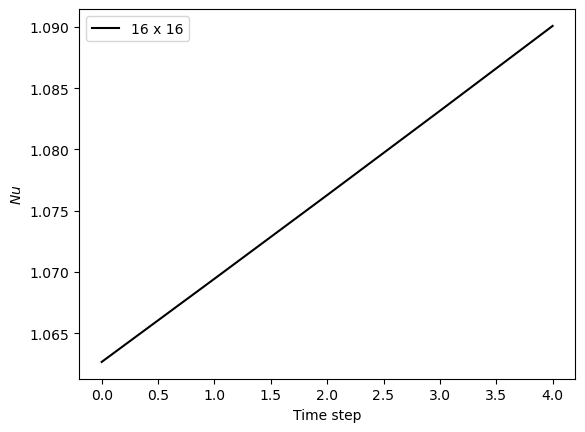

In [17]:
if uw.mpi.rank == 0:
        import matplotlib.pyplot as plt
        # plot how Nu is evolving through time
        fig,ax = plt.subplots(dpi = 100)

        #ax.hlines(42.865, 0, 2000, linestyle = "--", linewidth = 0.5, color = "gray", label = r"Benchmark $v_{rms}$")
        ax.plot(np.arange((~np.isnan(NuVal)).sum()), 
                NuVal[~np.isnan(NuVal)], 
                color = "k", 
                label = str(res) + " x " + str(res))

        ax.legend()
        ax.set_xlabel("Time step")
        ax.set_ylabel(r"$Nu$", color = "k")

        #ax.set_xlim([0, 2000])
        #ax.set_ylim([0, 100])

In [18]:
# Calculate benchmark values
if uw.mpi.rank == 0:
    print("RMS velocity at the final time step is {}.".format(v_rms()))
    print("Nusselt number at the final time step is {}.".format(Nu))

RMS velocity at the final time step is 22.503371856692063.
Nusselt number at the final time step is 1.09007922774252.


### Post-run analysis - change to EBA values

**Benchmark values**
The loop above outputs $v_{rms}$ as a general statistic for the system. For further comparison, the benchmark values for the RMS velocity, $v_{rms}$, Nusselt number, $Nu$, and non-dimensional gradients at the cell corners, $q_1$ and $q_2$, are shown below for different Rayleigh numbers. All benchmark values shown below were determined in Blankenbach *et al.* 1989 by extroplation of numerical results. 

| $Ra$ | $v_{rms}$ | $Nu$ | $q_1$ | $q_2$ |
| ------------- |:-------------:|:-----:|:-----:|:-----:|
| 10$^4$ | 42.865 | 4.884 | 8.059 | 0.589 |
| 10$^5$ | 193.215 | 10.535 | 19.079 | 0.723 |
| 10$^6$ | 833.990 | 21.972 | 45.964 | 0.877 |

In [19]:
# some things to set-up before post-processing

# set expression for calculating sigma_zz
sigma_zz_fn = stokes.stress[1, 1]

dTdZ_calc.solve() # recalculate gradient of T along Z

  0 SNES Function norm 0.0222552 
  1 SNES Function norm 1.79098e-06 
Nonlinear SProj_1_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1


### Calculate the $Nu$ value
The Nusselt number is defined as: 

\begin{aligned}
Nu  =   -h\frac{ \int_{0}^{l} \partial_{z}T(x, z = h) dx} {\int_{0}^{l} T(x, z = 0) dx} 
\end{aligned}

In [20]:
up_int = surface_integral(meshbox, dTdZ.sym[0], up_surface_defn_fn)
lw_int = surface_integral(meshbox, t_soln.sym[0], lw_surface_defn_fn)

Nu = -up_int/lw_int

if uw.mpi.rank == 0:
    print("Calculated value of Nu: {}".format(Nu))

Calculated value of Nu: 1.09007922774252


### Calculate the non-dimensional gradients at the cell corners, $q_i$
The non-dimensional temperature gradient at the cell corner, $q_i$, is defined as: 
\begin{aligned}
q  =  \frac{-h}{\Delta T} \left( \frac{\partial T}{\partial z} \right)
\end{aligned}
   
Note that these values depend on the non-dimensional temperature gradient in the vertical direction, $\frac{\partial T}{\partial z}$.
These gradients are evaluated at the following points:

$q_1$ at $x=0$, $z=h$; $q_2$ at $x=l$, $z=h$;

$q_3$ at $x=l$, $z=0$; $q_4$ at $x=0$, $z=0$.   

In [21]:
# calculate q values which depend on the temperature gradient fields

# NOTE: for quadratic elements, may need to set boundary value (e.g. boxHeight) to 0.99999*value (e.g. 0.9999*boxHeight)
q1 = -(boxHeight/(tempMax - tempMin))*uw.function.evaluate(dTdZ.sym[0], np.array([[0., boxHeight]]))[0]
q2 = -(boxHeight/(tempMax - tempMin))*uw.function.evaluate(dTdZ.sym[0], np.array([[boxLength, boxHeight]]))[0]
q3 = -(boxHeight/(tempMax - tempMin))*uw.function.evaluate(dTdZ.sym[0], np.array([[boxLength, 0.]]))[0]
q4 = -(boxHeight/(tempMax - tempMin))*uw.function.evaluate(dTdZ.sym[0], np.array([[0., 0.]]))[0]

if uw.mpi.rank == 0:
    print('Rayleigh number = {0:.1e}'.format(Ra))
    print('q1 = {0:.3f}; q2 = {1:.3f}'.format(q1, q2))
    print('q3 = {0:.3f}; q4 = {1:.3f}'.format(q3, q4))

Rayleigh number = 1.0e+04
q1 = 1.513; q2 = 0.654
q3 = 1.393; q4 = 0.652


### Calculate the stress for comparison with benchmark value

The stress field for whole box in dimensionless units (King 2009) is:
\begin{equation}
\tau_{ij} = \eta \frac{1}{2} \left[ \frac{\partial v_j}{\partial x_i} + \frac{\partial v_i}{\partial x_j}\right].
\end{equation}
For vertical normal stress it becomes:
\begin{equation}
\tau_{zz} = \eta \frac{1}{2} \left[ \frac{\partial v_z}{\partial z} + \frac{\partial v_z}{\partial z}\right] = \eta \frac{\partial v_z}{\partial z}.
\end{equation}
This is calculated below.

In [22]:
# projection object for the stress in the zz direction

stress_calc = uw.systems.Projection(meshbox, sigma_zz)
stress_calc.uw_function = sigma_zz_fn
stress_calc.smoothing = 1.0e-3
stress_calc.petsc_options.delValue("ksp_monitor")
stress_calc.solve()

  0 SNES Function norm 48.4741 
  1 SNES Function norm 0.00197438 
Nonlinear SProj_2_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1


The vertical normal stress is dimensionalised as: 

$$
    \sigma_{t} = \frac{\eta_0 \kappa}{\rho g h^2}\tau _{zz} \left( x, z=h\right)
$$

where all constants are defined below. 

Finally, we calculate the topography defined using $h = \sigma_{top} / (\rho g)$. The topography of the top boundary calculated in the left and right corners as given in Table 9 of Blankenbach et al 1989 are:

| $Ra$          |    $\xi_1$  | $\xi_2$  |  $x$ ($\xi = 0$) |
| ------------- |:-----------:|:--------:|:--------------:|
| 10$^4$  | 2254.02   | -2903.23  | 0.539372          |
| 10$^5$  | 1460.99   | -2004.20  | 0.529330          |
| 10$^6$  | 931.96   | -1283.80  | 0.506490          |

In [23]:
# subtract the average value for the benchmark since the mean is set to zero 

mean_sigma_zz_top = -surface_integral(meshbox, 
                                     sigma_zz.sym[0], 
                                     up_surface_defn_fn)/boxLength


In [24]:
# Set parameters in SI units

grav = 10        # m.s^-2
height = 1.e6    # m 
rho  = 4.0e3     # g.m^-3
kappa  = 1.0e-6  # m^2.s^-1

eta0=1.e23

def calculate_topography(coord): # only coord has local scope

    sigma_zz_top = -uw.function.evaluate(sigma_zz.sym[0], coord) - mean_sigma_zz_top
    
    # dimensionalise 
    dim_sigma_zz_top  = ((eta0 * kappa) / (height**2)) * sigma_zz_top
    topography = dim_sigma_zz_top / (rho * grav)
    
    return topography



In [25]:
# topography at the top corners 
e1 = calculate_topography(np.array([[0, boxHeight]]))
e2 = calculate_topography(np.array([[boxLength, boxHeight]]))

# calculate the x-coordinate with zero stress
with meshbox.access():
    cond = meshbox.data[:, 1] == meshbox.data[:, 1].max()
    up_surface_coords = meshbox.data[cond]
    up_surface_coords[:, 1] = 0.999999*up_surface_coords[:, 1]

abs_topo = abs(calculate_topography(up_surface_coords))

min_abs_topo_coord = up_surface_coords[np.where(abs_topo == abs_topo.min())[0]].flatten()

if uw.mpi.rank == 0:
    print("Topography [x=0], [x=max] = {0:.2f}, {1:.2f}".format(e1[0], e2[0]))
    print("x where topo = 0 is at {0:.6f}".format(min_abs_topo_coord[0]))

Topography [x=0], [x=max] = 1007.98, -989.19
x where topo = 0 is at 0.500000
